#### 2

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


### ЕС

In [3]:
df_eu  <-  read.csv(file="../data_hts/hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [4]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [5]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [6]:
var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)
var_drift   <-  TRUE
var_constant   <-  TRUE

In [7]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, 
                         method = "ML" )
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)

    }

[1] 2000.00 2011.75 2012.00 2013.75
[1] 2001.00 2012.75 2013.00 2014.75
[1] 2002.00 2013.75 2014.00 2015.75
[1] 2003.00 2014.75 2015.00 2016.75
[1] 2004.00 2015.75 2016.00 2017.75
[1] 2005.00 2016.75 2017.00 2018.75


In [10]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
-25.10788,39.79210,1.0469576
-19.10680,30.64221,0.8587702
56.58739,73.48258,1.7092086
60.65981,66.00735,1.8157914
-63.86244,71.66316,1.9413245
85.23901,89.44994,2.4512776


In [11]:
colMeans(df_acc_test)

ME      RMSE      MAPE 
15.734847 61.839556  1.637222

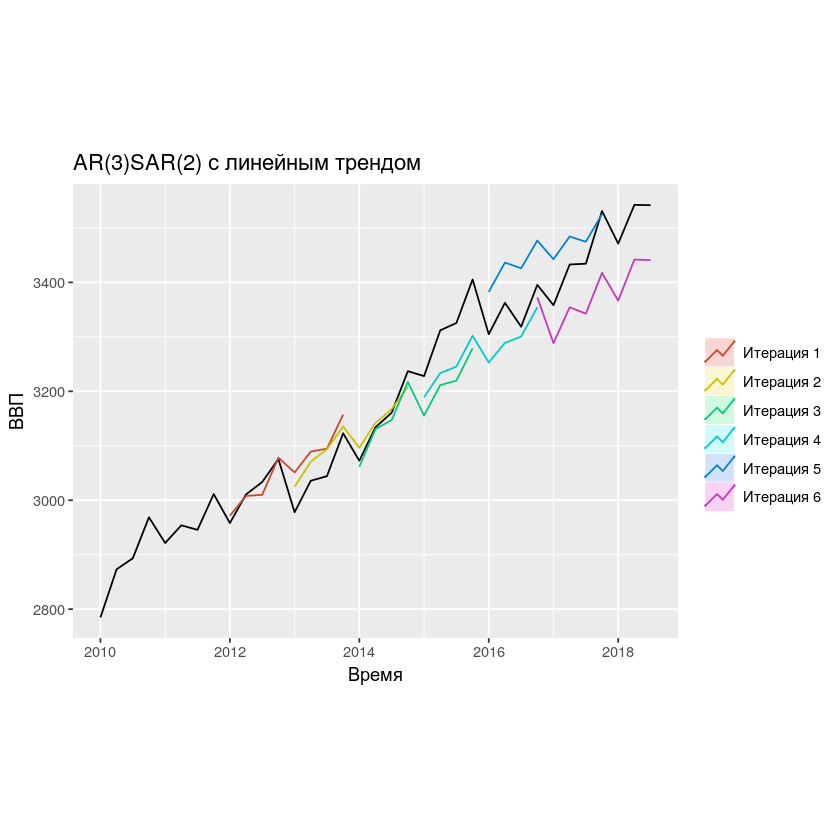

In [12]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [15]:
df_mean_acc <- readRDS("df_mean_acc.rds")
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,61.83956,353.9334,14532.34
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [16]:
df_mean_acc[1,1]  <-  colMeans(df_acc_test)[[2]]
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,61.83956,353.9334,14532.34
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [17]:
save_plots  <- list()

In [18]:
save_plots[[1]]  <-  plot_forecasts

In [19]:
df_acc  <-  df_acc_test

In [20]:
colnames(df_acc)  <-  colnames(ac[[1]])[var_acc_metrics] 
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [21]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [22]:
df_acc

ME,RMSE,MAPE,Iteration
-25.10788,39.79210,1.0469576,1
-19.10680,30.64221,0.8587702,5
56.58739,73.48258,1.7092086,9
60.65981,66.00735,1.8157914,13
-63.86244,71.66316,1.9413245,17
85.23901,89.44994,2.4512776,20


In [24]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

### США

In [10]:
df_eu  <-  read.csv(file="../data_hts/hts_us_ind_filled.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2005   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [11]:
var_h  <- 8
var_window  <-  28 - 1
var_topup  <-  2
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [12]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,0,0)
var_sarpdq   <-  c(0,0,0)
var_drift   <-  TRUE
var_constant   <-  TRUE

In [13]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, 
                         method = "ML" )
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2005.00 2011.75 2012.00 2013.75
[1] 2006.00 2012.75 2013.00 2014.75
[1] 2007.00 2013.75 2014.00 2015.75
[1] 2008.00 2014.75 2015.00 2016.75
[1] 2009.00 2015.75 2016.00 2017.75
[1] 2010.00 2016.75 2017.00 2018.75


In [31]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
212.93024,271.1597,1.3135845
561.96918,627.0069,3.4009006
440.47155,531.0550,2.7248342
440.33168,464.5370,2.5529095
115.07824,124.8080,0.6541428
75.80072,105.0337,0.4351706


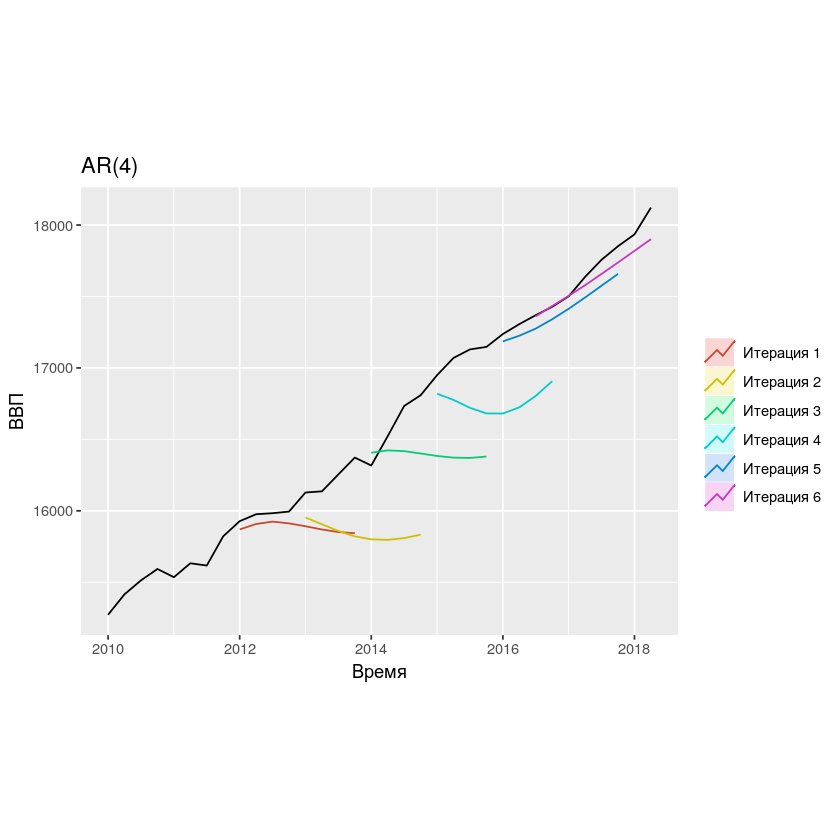

In [33]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(4)") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [34]:
df_mean_acc[1,2]  <- colMeans(df_acc_test)[[2]]
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,61.83956,353.9334,14532.34
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [35]:
save_plots[[3]]  <-  plot_forecasts

In [36]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

### РФ

In [15]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [16]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

### Top Level: AR(3)

In [17]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(11,0,0)
var_sarpdq   <-  c(2,0,0)
var_drift   <-  TRUE
var_constant   <-  TRUE

In [18]:
require(svMisc)

Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [19]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0
err_list  <- c()
for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
#         if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#             train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
#         }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
#     }
}
    
#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         test <- window(gdp_agg, start=test_start-var_topup/var_freq)
#     }else{    
        test <- window(gdp_agg, start=test_start, end=test_end)
        
#     }
    
#     m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, 
#                          method = "ML" )
    
    model  <-  tryCatch( list(Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method = "ML") , 0), 
            error = function(e) 
               {tryCatch( list(Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method = "CSS"), i+1), 
                         error = function(e)              
                            list(Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method = "CSS", optim.method = "CG"), i+1))
                         }
    )

    
    m_top[[k]]  <- model[[1]]
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )
                
    if (model[[2]]!=0){
        err_list <-  c(err_list,model[[2]])
    }              
                
                
    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
                
    progress(i, progress.bar = TRUE)
    
    
                
    }

          0%---------25%---------50%---------75%--------100%
Progress: ||

In [45]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
-11116.729,13183.367,565.6800
-11114.901,12543.680,288.6285
-6743.158,9484.543,141.3557
-16598.195,18998.010,297.8399
-15686.192,17505.417,195.3627


In [46]:
colMeans(df_acc_test)

ME        RMSE        MAPE 
-12251.8349  14343.0034    297.7734

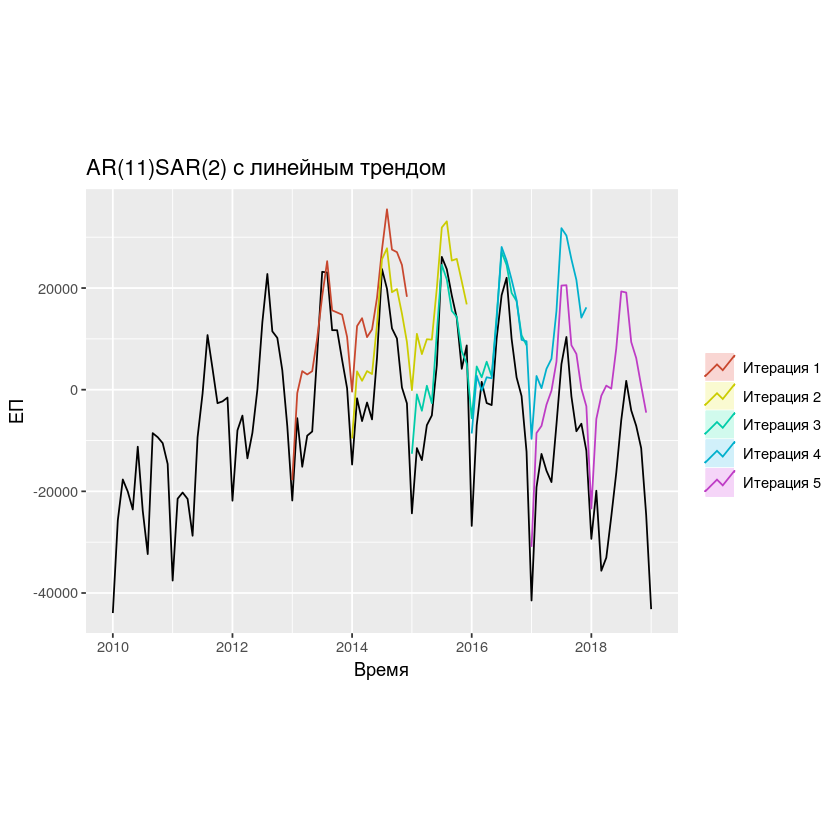

In [48]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ЕП') +
    ggtitle("AR(11)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [49]:
df_mean_acc[1,3]  <- colMeans(df_acc_test)[[2]]
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,61.83956,353.9334,14343
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [50]:
save_plots[[5]]  <-  plot_forecasts

In [51]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

In [54]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,61.83956,353.9334,14343
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [55]:
saveRDS(df_mean_acc, "df_mean_acc.rds")

In [21]:
top_models_list  <-  readRDS("../top_models_list.rds")
top_models_list[[2]]  <- this_models_list
saveRDS(top_models_list, "df_mean_acc.rds")

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”

[[1]]
[[1]][[1]]
[[1]][[1]][[1]]
Series: msts(train, seasonal.periods = var_freq) 
ARIMA(2,0,0)(1,0,0)[4] with drift 

Coefficients:
         ar1      ar2    sar1  intercept    drift
      1.4138  -0.6210  0.9127  2139.9301  17.9593
s.e.  0.1135   0.1132  0.0461   179.8832   4.4154

sigma^2 estimated as 1005:  log likelihood=-235.89
AIC=483.78   AICc=485.82   BIC=495

[[1]][[1]][[2]]
Series: msts(train, seasonal.periods = var_freq) 
ARIMA(2,0,0)(1,0,0)[4] with drift 

Coefficients:
         ar1      ar2    sar1  intercept    drift
      1.4110  -0.6200  0.9069  2219.0563  17.4781
s.e.  0.1144   0.1139  0.0478   174.0724   4.3510

sigma^2 estimated as 1017:  log likelihood=-236.05
AIC=484.09   AICc=486.14   BIC=495.32

[[1]][[1]][[3]]
Series: msts(train, seasonal.periods = var_freq) 
ARIMA(2,0,0)(1,0,0)[4] with drift 

Coefficients:
         ar1      ar2    sar1  intercept    drift
      1.4030  -0.6173  0.9187  2308.0904  16.8391
s.e.  0.1163   0.1162  0.0459   186.9164   4.4926

sigma

In [ ]:
this_models_list